### 관리권역설정 1차 분석접근
9_etc 에는 채택되지 않은 관리권역설정 분석 코드가 있습니다. 

### 2023_강남구 재고부족대여소 사용패턴시각화

In [229]:
query= """
-- Generate all possible hours for every day in the year 2023 without using subqueries
WITH Hours AS (
  SELECT 
    EXTRACT(DATE FROM datetime) AS day,
    EXTRACT(HOUR FROM datetime) AS hour,
    rental_location_id
  FROM 
    UNNEST(GENERATE_TIMESTAMP_ARRAY(TIMESTAMP("2023-01-01 00:00:00"), TIMESTAMP("2023-12-31 23:00:00"), INTERVAL 1 HOUR)) AS datetime,
    UNNEST(["ST-2688", "ST-2678", "ST-1178", "ST-1881", "ST-1575", "ST-1895", "ST-1680", "ST-2867", "ST-1171", "ST-1884", "ST-2671", "ST-1577", "ST-1896", "ST-1365", "ST-2837"]) AS rental_location_id
),
RentalCounts AS (
  -- Calculate rental counts per location and hour for 2023
  SELECT
    EXTRACT(DATE FROM A.Date_and_time_of_rental) AS day,
    EXTRACT(HOUR FROM A.Date_and_time_of_rental) AS hour,
    A.Rental_Location_ID,
    A.Rental_location_number,
    COUNT(A.Bike_number) AS rental_count
  FROM 
    `multi-final-project.Rental_usage_history.Rental_usage_history_*` AS A
  JOIN 
    `multi-final-project.Rental_Location_ID_master.Rental_Station_ID_master` AS B
  ON 
    A.Rental_Location_ID = B.Rental_Location_ID
  WHERE 
    _TABLE_SUFFIX BETWEEN '2301' AND '2312'
    AND REGEXP_CONTAINS(B.Address_gu, '강남구')
    AND A.Rental_location_ID IN ( "ST-2688", "ST-2678", "ST-1178", "ST-1881", "ST-1575", "ST-1895", "ST-1680", "ST-2867", "ST-1171", "ST-1884", "ST-2671", "ST-1577", "ST-1896", "ST-1365", "ST-2837")
  GROUP BY
    day, hour, A.Rental_Location_ID, A.Rental_location_number
)
-- Join all possible hours and locations with actual rental counts to fill gaps and pivot the data
SELECT
  hour,
  AVG(IF(rental_location_id = "ST-2688", rental_count, 0)) AS ST_2688,
  AVG(IF(rental_location_id = "ST-2678", rental_count, 0)) AS ST_2678,
  AVG(IF(rental_location_id = "ST-1178", rental_count, 0)) AS ST_1178,
  AVG(IF(rental_location_id = "ST-1881", rental_count, 0)) AS ST_1881,
  AVG(IF(rental_location_id = "ST-1575", rental_count, 0)) AS ST_1575,
  AVG(IF(rental_location_id = "ST-1895", rental_count, 0)) AS ST_1895,
  AVG(IF(rental_location_id = "ST-1680", rental_count, 0)) AS ST_1680,
  AVG(IF(rental_location_id = "ST-2867", rental_count, 0)) AS ST_2867,
  AVG(IF(rental_location_id = "ST-1171", rental_count, 0)) AS ST_1171,
  AVG(IF(rental_location_id = "ST-1884", rental_count, 0)) AS ST_1884,
  AVG(IF(rental_location_id = "ST-2671", rental_count, 0)) AS ST_2671,
  AVG(IF(rental_location_id = "ST-1577", rental_count, 0)) AS ST_1577,
  AVG(IF(rental_location_id = "ST-1896", rental_count, 0)) AS ST_1896,
  AVG(IF(rental_location_id = "ST-1365", rental_count, 0)) AS ST_1365,
  AVG(IF(rental_location_id = "ST-2837", rental_count, 0)) AS ST_2837
FROM (
  SELECT
    hour,
    rental_location_id,
    IFNULL( (
      SELECT rental_count
      FROM RentalCounts
      WHERE RentalCounts.day = Hours.day
      AND RentalCounts.hour = Hours.hour
      AND RentalCounts.Rental_Location_ID = Hours.rental_location_id
    ), 0) AS rental_count
  FROM
    Hours
)
-- WHERE
--   day BETWEEN '2023-03-01' AND '2023-11-30'
GROUP BY
  hour
ORDER BY
  hour
LIMIT 1000;

"""

In [230]:
usaged_pattern = client.query(query).to_dataframe()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [231]:
usaged_pattern.head()

,hour,ST_2688,ST_2678,ST_1178,ST_1881,ST_1575,ST_1895,ST_1680,ST_2867,ST_1171,ST_1884,ST_2671,ST_1577,ST_1896,ST_1365,ST_2837
0,0,0.101918,0.052420,0.052055,0.047671,0.054795,0.052603,0.038721,0.047671,0.069041,0.027763,0.026301,0.034521,0.027763,0.043105,0.041279
1,1,0.078174,0.046027,0.049498,0.034703,0.016256,0.056438,0.027945,0.007123,0.067945,0.021918,0.019178,0.033973,0.017717,0.036895,0.023014
2,2,0.053151,0.031781,0.042374,0.016621,0.014795,0.044749,0.029406,0.004566,0.059726,0.012237,0.015342,0.031963,0.015890,0.026849,0.017352
3,3,0.023927,0.020822,0.031781,0.012055,0.023744,0.028676,0.025936,0.002009,0.032146,0.016621,0.008767,0.022466,0.009680,0.022648,0.011142
4,4,0.017900,0.005845,0.015342,0.005845,0.010046,0.017900,0.014429,0.002557,0.017534,0.003288,0.005297,0.017352,0.007123,0.014247,0.013333


In [243]:
import seaborn as sns
import matplotlib.pyplot as plt

# 대여소 그룹 정의
groups = [
    ['ST_2688',	'ST_2678',	'ST_1178',	'ST_1881',	'ST_1575'],
    ['ST_1895',	'ST_1680',	'ST_2867',	'ST_1171',	'ST_1884'],
    ['ST_2671',	'ST_1577',	'ST_1896',	'ST_1365',	'ST_2837']
]

# 그래프를 그리는 함수
def plot_group_patterns(df, groups, group_number):
    plt.figure(figsize=(15, 8))
    for target in groups[group_number - 1]:
        sns.lineplot(x='hour', y=target, data=df, label=target)
    
    plt.title(f'Bike Rental Patterns for Group {group_number}')
    plt.xlabel('Hour')
    plt.ylabel('Rental Count')
    plt.legend(title='Rental Locations')
    plt.show()

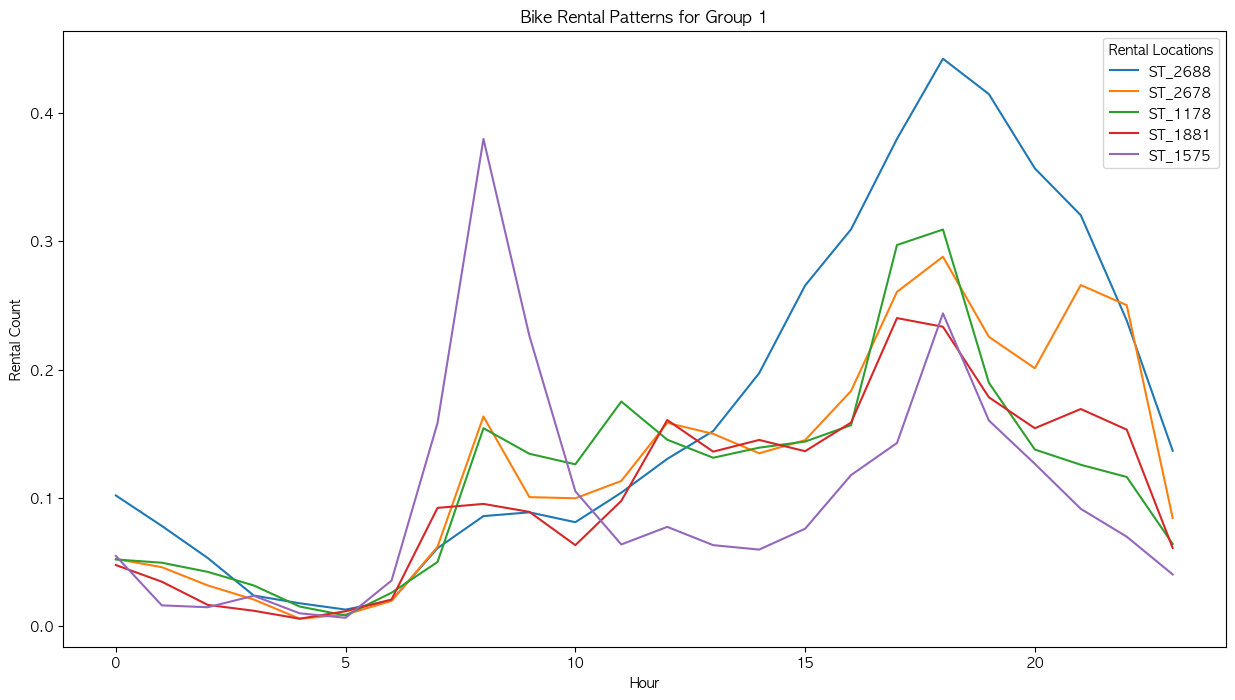

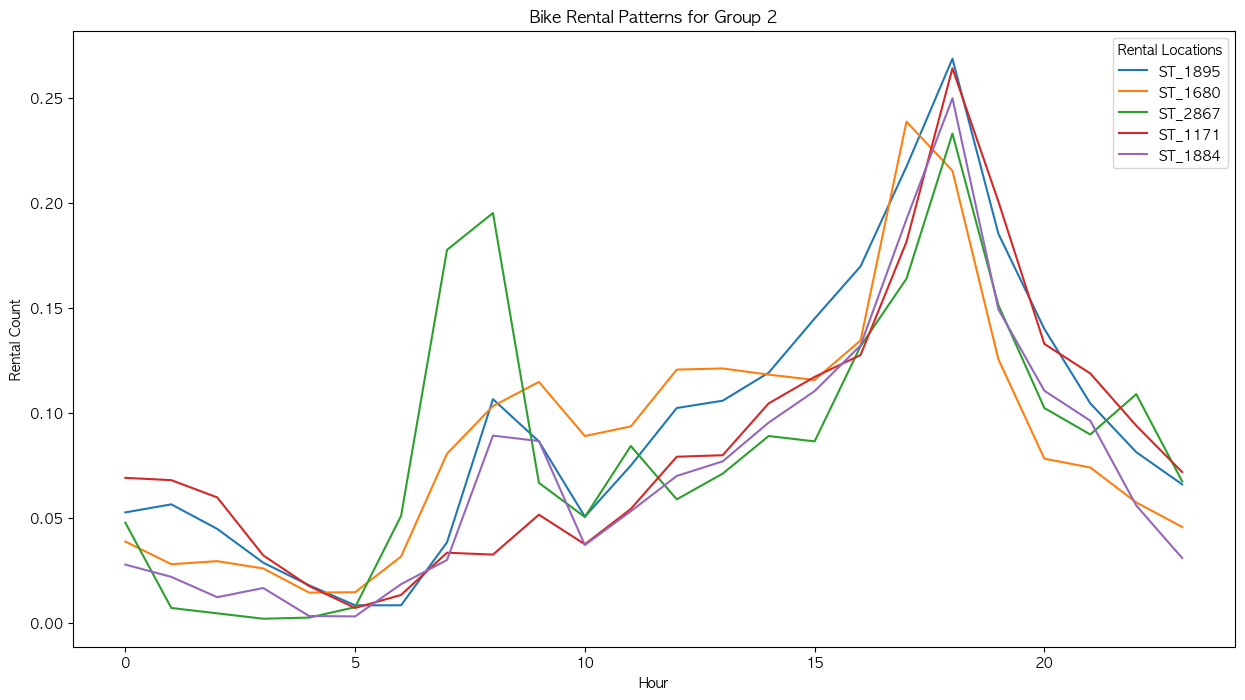

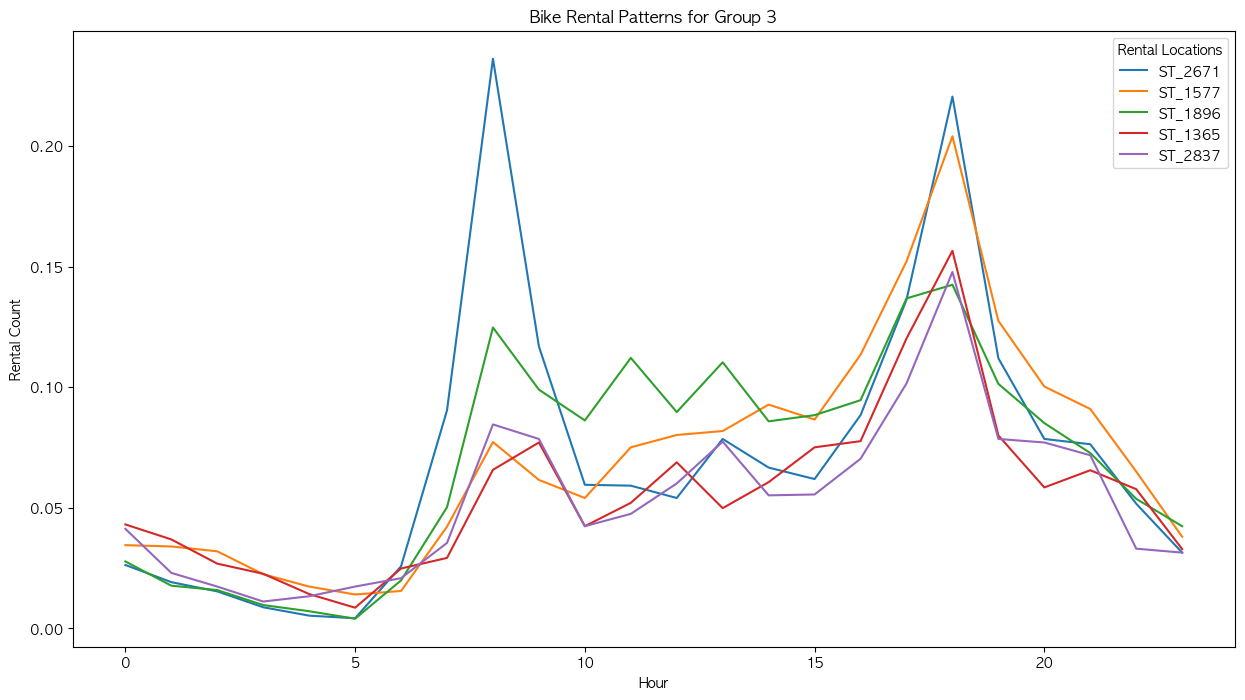

In [244]:
# 사용 예시
plot_group_patterns(usaged_pattern, groups, group_number=1)  # 첫 번째 그룹
plot_group_patterns(usaged_pattern, groups, group_number=2)  # 두 번째 그룹
plot_group_patterns(usaged_pattern, groups, group_number=3)  # 세 번째 그룹

### 2023 대여소 시간당 평균 대여 가능수량

In [161]:
import seaborn as sns
import matplotlib.pyplot as plt

# 평균값 추출
station_means = stocks_df.describe().loc['mean'].drop('hour')
stations = station_means.index
means = station_means.values

In [162]:
station_means

ST_1171    11.774979
ST_1172     8.635095
ST_1173    11.520516
ST_1174    15.855623
ST_1177     7.124749
             ...    
ST_960      4.064089
ST_961      5.790706
ST_962      4.796027
ST_963      3.926097
ST_966      2.855031
Name: mean, Length: 165, dtype: Float64

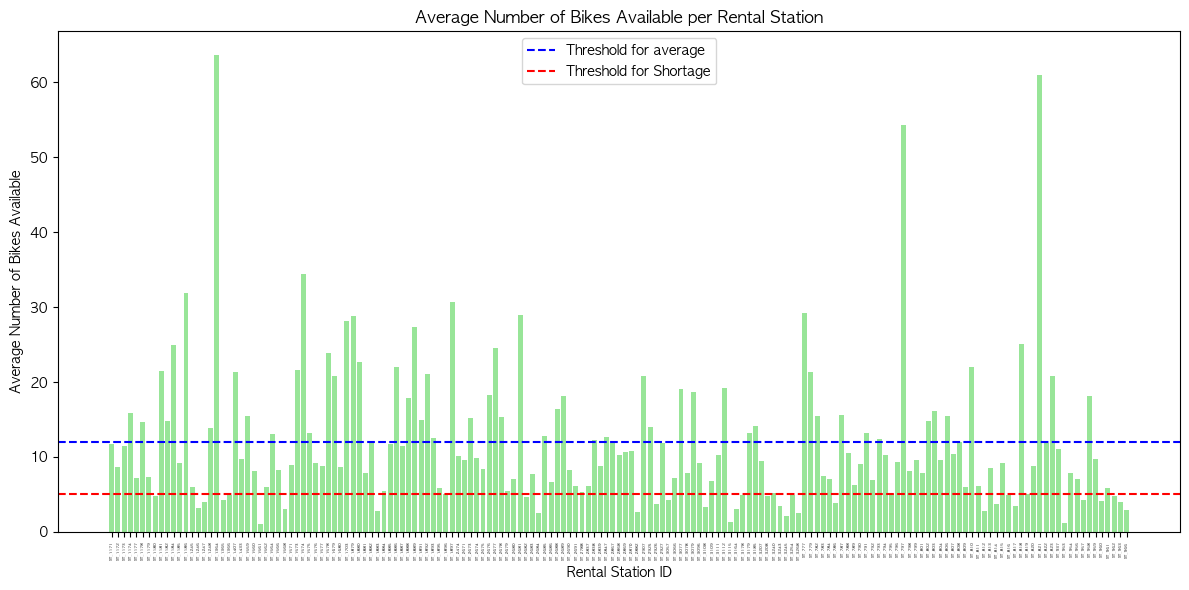

In [107]:
# 바 차트 생성
plt.figure(figsize=(12, 6))
plt.bar(stations, means, color=(0.2, 0.8, 0.2, 0.5))
plt.xlabel('Rental Station ID')
plt.ylabel('Average Number of Bikes Available')
plt.xticks(rotation=90,fontsize=3)
plt.title('Average Number of Bikes Available per Rental Station')
plt.axhline(y=12, color='', linestyle='--', label='Threshold for average')
plt.axhline(y=5, color='r', linestyle='--', label='Threshold for Shortage') # 기준선 추가 (예: 평균 5 미만은 부족한 상태로 표시)
plt.legend()
plt.tight_layout()
plt.show()

### 재고 넘치는곳, 부족한 곳 임계선 잡고 리스트 추출

In [139]:
# 평균 자전거 수가 5개이하 대여소 필터링
stations_fewer_than_5 = station_means[station_means <= 5]
count_fewer_than_5 = stations_fewer_than_5.count()

In [ ]:
print("평균 자전거 수가 5개보다 적은 대여소:")
print(stations_fewer_than_5)
print(count_fewer_than_5)

In [140]:
# 평균 자전거 수가 12개이하 적은 대여소 필터링
stations_less_than_12 = station_means[ station_means < 12]
count_less_than_12 = stations_less_than_12.count()

In [ ]:
print("\n평균 자전거 수가 12개보다 적은 대여소:")
print(stations_less_than_12)
print(count_less_than_12)

In [150]:
# 평균 자전거 수가 상위10개 대여소 필터링
# station_means를 내림차순으로 정렬하고 상위 10개 선택
stations_asc = station_means.sort_values(ascending=False)

In [151]:
stations_asc

ST_1364    63.644318
ST_821     60.952347
ST_797      54.34232
ST_1574    34.368216
ST_1186    31.862481
             ...    
ST_3268     2.469907
ST_3245      2.07142
ST_3115      1.38075
ST_953       1.23046
ST_1561     1.015254
Name: mean, Length: 165, dtype: Float64

In [152]:
# 생략 없이 전체 내용을 출력
pd.set_option('display.max_rows', None)
print(stations_asc)
pd.reset_option('display.max_rows')

ST_1364    63.644318
ST_821     60.952347
ST_797      54.34232
ST_1574    34.368216
ST_1186    31.862481
ST_1897    30.706634
ST_777     29.225139
ST_2681    28.891451
ST_1879     28.75677
ST_1703    28.089985
ST_1889    27.315951
ST_818     25.119309
ST_1184    24.989476
ST_2677    24.551023
ST_1578    23.846045
ST_1880    22.643964
ST_1886    22.045288
ST_810     21.948327
ST_1573      21.6442
ST_1181    21.459856
ST_1407    21.385834
ST_779     21.281069
ST_1892    21.102637
ST_2907    20.834575
ST_1679    20.823342
ST_823     20.787159
ST_3112    19.177131
ST_3077    19.048835
ST_3079    18.631311
ST_2676    18.232352
ST_2689    18.153009
ST_958     18.128296
ST_1888    17.849001
ST_2688    16.438217
ST_803     16.131016
ST_1174    15.855623
ST_787     15.625399
ST_782     15.520634
ST_806     15.492846
ST_1559    15.465768
ST_2678    15.302117
ST_2673    15.192149
ST_1891    14.974104
ST_802     14.801348
ST_1182    14.796382
ST_1178    14.726499
ST_3185    14.179496
ST_2925     1

### 관리필요한 대여소 지도 시각화